In [1]:
# Import libraries

# Basic
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.ensemble import GradientBoostingRegressor


# My own cleaning libraryb
import cleaning_tools as ct
import tools

# For reloading my tools, while working on them
from importlib import reload

import warnings
warnings.filterwarnings('ignore')

seed = 42

In [2]:
for c in num_cols:
    print(c)

NameError: name 'num_cols' is not defined

In [3]:
# Load Training Data
data = tools.load_data('../data/train.csv')

def clean(data):
    # Transform columns
    data['Total_SF']      = data['Total_Bsmt_SF'] + data['1st_Flr_SF'] + data['2nd_Flr_SF']
    data['porch_area']    = data['Open_Porch_SF'] + data['Enclosed_Porch'] + data['3Ssn_Porch'] + data['Screen_Porch']
    data['Overall_Qual2'] = data['Overall_Qual']**2
    #data['Year_Built2']   = data['Year_Built']**2
    #data['SBrkr'] = data['Electrical'].apply(lambda x: 1 if x=="SBrkr" else 0)

    data.drop(['Total_Bsmt_SF', '1st_Flr_SF', '2nd_Flr_SF'], axis=1, inplace=True)
    data.drop('Garage_Cars', axis=1, inplace=True)
    data.drop('Pool_Area',   axis=1, inplace=True)
    data.drop('MS_SubClass', axis=1, inplace=True)
    data.drop('Kitchen_AbvGr', axis=1, inplace=True)
    data.drop(['Id', 'PID'], axis=1, inplace=True)
    
    # Map to number
    data = ct.map_to_number(data)
    
    return data

data = clean(data)

# Outliers :
data = data[data['Lot_Frontage'] < 250].copy()
data = data[data['Lot_Area'] < 20000]



# Split X/y
y = data[['SalePrice']].copy()
X = data.drop('SalePrice', axis=1)
X.drop(['Open_Porch_SF', 'Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch'], axis=1, inplace=True)

# Add
num_cols = [c for c in X.columns if X[c].dtype in [np.int64, np.float64]]
str_cols = [c for c in X.columns if X[c].dtype not in [np.int64, np.float64]]
X = X[num_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

imputer = Imputer(strategy='median').fit(X_train)
X_train = imputer.transform(X_train)
X_test  = imputer.transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)


In [97]:
X.shape

(1689, 42)

best train k:  32
best test k:  32


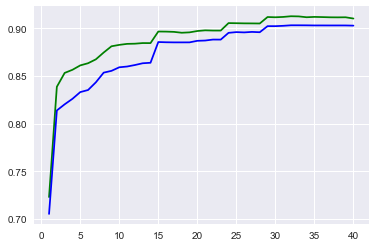

In [4]:
R = Ridge()
scores1 = []
scores2 = []
ks = [i for i in range(1, X_train.shape[1]+1)]
for k in ks:
    selector = SelectKBest(k=k)
    selector.fit(X_train, y_train)
    
    x1 = selector.transform(X_train)
    x2 = selector.transform(X_test)
    
    cvs = cross_val_score(R, x1, y_train, cv=3)
    
    R.fit(x1, y_train)
    s2 = R.score(x2, y_test)
    
    scores1.append(cvs.mean())
    scores2.append(s2)

f, ax = plt.subplots()
ax.plot(ks, scores1, 'green')
ax.plot(ks, scores2, 'blue')
print('best train k: ',  ks[scores1.index(max(scores1))])
print('best test k: ',  ks[scores2.index(max(scores2))])

In [5]:
selector = SelectKBest(k=ks[scores2.index(max(scores2))])
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

In [152]:
params = {'n_estimators': [250, 300, 350],
          'learning_rate': [0.5, 0.6, 0.65],
          'alpha' : [0.0001],
          'max_depth' : [2]
         }

estimator = GradientBoostingRegressor()
GSV = GridSearchCV(estimator, param_grid=params, n_jobs=-1)
GSV.fit(X_train, y_train)
best = GSV.best_params_
print(best)

{'alpha': 0.0001, 'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 250}


In [150]:
GSV.best_score_

0.88063718070395314

In [153]:
R = GradientBoostingRegressor(n_estimators = best['n_estimators'],
                              max_depth=best['max_depth'],
                              alpha=best['alpha'],
                              learning_rate=best['learning_rate'],
                             )
R.fit(X_train, y_train)
print(R.score(X_train, y_train))
print(R.score(X_test, y_test))

0.990011618466
0.915523100674


In [6]:
L = Ridge()
L.fit(X_train, y_train)

print(L.score(X_train, y_train))
print(L.score(X_test, y_test))

0.923214914557
0.903224388377


In [155]:
data_test = tools.load_data('../data/test.csv')
ids       = data_test[['Id']].copy()
data_test = clean(data_test)

X_final = data_test[num_cols]
X_final = imputer.transform(X_final)
X_final = scaler.transform(X_final)
X_final = selector.transform(X_final)
y_final = pd.DataFrame(R.predict(X_final), columns=['SalePrice'])

final_df = pd.concat([ids, y_final], axis=1)
final_df.to_csv('sub5_gbr.csv', index=False)

In [68]:
y_final.mean()

SalePrice    181589.908798
dtype: float64